In [225]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Dense, GRU, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow
import pandas as pd
import re
from nltk.corpus import stopwords
from pymystem3 import Mystem
import fasttext
import numpy
import matplotlib.pyplot as plt

Импорт входных данных

In [2]:
# train = pd.read_csv('markuped.csv', header=0, names=['Index', 'Title', 'Description', 'Class'], engine='python')
train = pd.read_csv('markuped_balanced.csv', header=0, names=['Index', 'Title', 'Description', 'Class'], engine='python')

# Преобразование текста новостей в string
train['Description'] = pd.Series(train['Description'], dtype="str")

news = train['Description']
print(type(news))
news[:5]

<class 'pandas.core.series.Series'>


0    Украинские войска утром в среду выпустили 12 с...
1    Любые попытки оттеснить Россию с Ближнего Вост...
2    Запад заранее планировал "заговор" против Росс...
3    Бывший министр иностранных дел КНДР Ли Ён Хо и...
4    Более 100 человек погибли и более 300 ранены в...
Name: Description, dtype: object

Правильные метки y_train

In [3]:
y_train = train['Class']
y_train

0       1
1       0
2       0
3       0
4       1
       ..
4857    0
4858    0
4859    0
4860    0
4861    0
Name: Class, Length: 4862, dtype: int64

In [4]:
def get_data_num_of_classes(class_number: int) -> int:
    return len(list(filter(lambda i: i == class_number, y_train)))

print(f"Ложь: {get_data_num_of_classes(0)}")
print(f"Истина: {get_data_num_of_classes(1)}")

Ложь: 2432
Истина: 2430


In [5]:
# y_train = tensorflow.keras.utils.to_categorical(y_train - 1, 4)

In [6]:
# y_train

Обработка входных данных

Токенизация

In [7]:
def words_numbers_only(text: str) -> list:
    regex = re.compile(r"\b[А-Яа-яЁё0-9A-Za-z-.,:]+\b")

    try:
        return regex.findall(text.lower())
    except:
        return []


tokens = [words_numbers_only(i) for i in news]

In [248]:
' '.join(tokens[0])

'украинские войска утром в среду выпустили 12 снарядов калибром 122 и 155 миллиметров по донецку и ясиноватой сообщило представительство днр в совместном центре по контролю и координации вопросов связанных с военными преступлениями украины сцкк ясиноватая расположена примерно в 25 километрах к северу от донецка в ней находится одна из крупнейших в бывшем ссср железнодорожных станций артиллерия калибром 155 миллиметров применяется странами нато сша поставили киеву дальнобойные гаубицы m777 калибром 155 миллиметров украинские войска активно используют их для обстрела городов донецкой и луганской народных республик также украинским войскам были поставлены немецкие самоходные артиллерийские установки pzh 2000 польские сау krab и французские сау caesar использующие снаряды такого калибра'

In [9]:
print(len(tokens[0]))

106


Нормализация

In [10]:
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('russian')
print(STOP_WORDS)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [11]:
def remove(sentences: list) -> list:
    return [word for word in sentences if not word in STOP_WORDS]


def remove_stopwords(text: list) -> list:
    return [remove(sentences) for sentences in text]


normalized_text = remove_stopwords(tokens)

In [247]:
' '.join(normalized_text[0])

'украинские войска утром среду выпустили 12 снарядов калибром 122 155 миллиметров донецку ясиноватой сообщило представительство днр совместном центре контролю координации вопросов связанных военными преступлениями украины сцкк ясиноватая расположена примерно 25 километрах северу донецка находится одна крупнейших бывшем ссср железнодорожных станций артиллерия калибром 155 миллиметров применяется странами нато сша поставили киеву дальнобойные гаубицы m777 калибром 155 миллиметров украинские войска активно используют обстрела городов донецкой луганской народных республик также украинским войскам поставлены немецкие самоходные артиллерийские установки pzh 2000 польские сау krab французские сау caesar использующие снаряды такого калибра'

In [13]:
print(len(normalized_text[0]))

86


Лемматизация

In [14]:
from pymystem3 import Mystem
pymystem = Mystem(entire_input=False)

In [15]:
def lemmatize_state(state: list) -> list:
    return pymystem.lemmatize(' '.join(state))


def lemmatize_text(text: list) -> list:
    return [lemmatize_state(senteces) for senteces in text]


lemmas = lemmatize_text(normalized_text)

In [246]:
' '.join(lemmas[0])

'украинский войско утро среда выпускать снаряд калибр миллиметр донецк ясиноватая сообщать представительство днр совместный центр контроль координация вопрос связанный военный преступление украина сцкк ясиноватая располагать примерно километр север донецк находиться один крупный бывший ссср железнодорожный станция артиллерия калибр миллиметр применяться страна нато сша поставлять киев дальнобойный гаубица калибр миллиметр украинский войско активно использовать обстрел город донецкий луганский народный республика также украинский войско поставлять немецкий самоходный артиллерийский установка pzh польский сау krab французский сау caesar использовать снаряд такой калибр'

Векторизация

In [18]:
# Скачивание модели
# import fasttext.util as util
# util.download_model('ru', if_exists='ignore')

In [245]:
import fasttext
ft = fasttext.load_model('cc.ru.300.bin')

In [20]:
ft['войско']

array([ 0.07347412,  0.06768222, -0.1850512 , -0.02559868, -0.07886638,
       -0.02091241,  0.00124729, -0.00111481, -0.04690955, -0.08299466,
       -0.00938793,  0.04262696,  0.03005699, -0.04320898,  0.1071489 ,
       -0.05166882, -0.01515542,  0.0507789 ,  0.05058671, -0.0164602 ,
        0.02960297, -0.08354642, -0.01093756,  0.04751961,  0.01469619,
       -0.00037444, -0.04775606,  0.09505374,  0.05094872,  0.0531891 ,
        0.08460937,  0.13604929, -0.09785382, -0.05007789, -0.03990616,
        0.00441105,  0.01924629, -0.10844938,  0.04085549, -0.12569788,
        0.05715404, -0.04245844,  0.02349903, -0.02649097,  0.00939097,
        0.0184968 ,  0.1025246 , -0.05342851, -0.03830729,  0.06688714,
        0.03365568, -0.05296698,  0.03451109,  0.01243417, -0.04489016,
        0.02096738,  0.05412815,  0.00333786, -0.02442639,  0.02500737,
       -0.04637808,  0.02657043, -0.08240118,  0.0432664 , -0.02235895,
       -0.08354683,  0.04404042,  0.0257584 , -0.11183021,  0.00

In [21]:
def vectorize(state: list) -> list:
    result = [j for word in state for j in ft[word]]
    return result


def vectorize_text(text: list) -> list:
    return [vectorize(i) for i in text] 


vectorized_text = vectorize_text(lemmas)
vectorized_text = [l for l in vectorized_text]

In [22]:
len(vectorized_text)

4862

In [243]:
' '.join(list(map(lambda x: str(x), vectorized_text[0])))

'-0.024824362 0.022561273 -0.036507394 0.016613971 0.050882615 0.0030197054 0.027948923 -0.012883544 0.007810979 -0.02735453 -0.0018613131 0.046857364 0.0067064194 0.026661966 -0.008673898 0.029483743 -0.0038606848 0.011623207 -0.021352917 0.008396965 0.0067768344 -0.028398918 -0.017046535 0.06194044 -0.016667858 -0.005451218 0.0073186094 -0.026002958 0.02211566 0.059738755 -0.0038226892 -0.018629791 -0.028695012 -0.025755858 0.004782569 -0.045387387 -0.008388111 -0.06842996 -0.039863903 -0.015302933 -0.008058233 -0.030183043 0.053053036 -0.034011275 -0.07714776 -0.0707494 -0.05531067 -0.023521004 0.029785326 0.0069874236 0.0056766164 0.02252292 0.032201927 0.052649856 0.0026145147 0.00054042495 -0.016436543 -0.05148007 -0.007117725 -0.021697823 0.043344606 0.0042602075 -0.017347677 -0.02247051 -0.026328769 0.046781447 -0.044950444 -0.042077262 -0.030885568 -0.014451686 -0.026620097 -0.00965715 -0.022056771 0.008995001 0.0008197636 0.019613111 0.049966883 -0.039328698 0.010971014 0.007

Находим максимальную длину статьи

In [241]:
list_of_news_length = list(map(lambda vtext: len(vtext), vectorized_text))
print(list_of_news_length[:50])

max(list_of_news_length)

[23400, 33300, 62700, 54600, 15900, 39600, 54900, 14400, 26100, 41700, 29700, 27600, 41400, 83700, 43500, 52800, 35700, 25500, 11400, 32700, 35100, 46500, 43500, 27600, 76800, 21900, 20700, 40200, 28500, 23700, 72300, 24900, 26700, 38100, 48000, 19800, 33300, 54000, 27600, 33300, 13200, 24300, 34500, 10800, 30000, 42600, 27300, 21900, 23700, 153600]


795300

Находим количество статей по длине > 100000

In [240]:
print(len(list(filter(lambda i: i > 100000, list_of_news_length))))

85


Преобразование векторов входного набора в один размер

In [202]:
MAX_NEWS_LEN = 100000

In [204]:
x_train = pad_sequences(vectorized_text, maxlen=MAX_NEWS_LEN, dtype='float32')

In [205]:
len(x_train)

4862

In [206]:
x_train.shape

(4862, 100000)

In [207]:
x_train

array([[ 0.        ,  0.        ,  0.        , ..., -0.07661333,
         0.04728675, -0.01101851],
       [ 0.        ,  0.        ,  0.        , ..., -0.00197083,
        -0.08645949, -0.05651738],
       [ 0.        ,  0.        ,  0.        , ..., -0.51967937,
        -0.0252047 , -0.08378075],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.08876067,
        -0.01946183, -0.02782871],
       [ 0.        ,  0.        ,  0.        , ...,  0.03055471,
        -0.0393386 , -0.02999344],
       [ 0.        ,  0.        ,  0.        , ...,  0.01193358,
        -0.0085796 , -0.03413292]], dtype=float32)

In [208]:
x_train = numpy.reshape(x_train, (x_train.shape[0], 1, MAX_NEWS_LEN))

In [209]:
x_train.shape

(4862, 1, 100000)

In [210]:
x_train[0]

array([[ 0.        ,  0.        ,  0.        , ..., -0.07661333,
         0.04728675, -0.01101851]], dtype=float32)

Построение архитектуры нейронной сети

In [211]:
model = Sequential()

model.add(LSTM(32, input_shape=(1, MAX_NEWS_LEN), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

Компиляция нейронной сети

In [212]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

Просмотр ахитектуры нейронной сети

In [213]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 1, 32)             12804224  
                                                                 
 dropout_8 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_19 (LSTM)              (None, 1, 64)             24832     
                                                                 
 dropout_9 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_20 (LSTM)              (None, 1, 128)            98816     
                                                                 
 dropout_10 (Dropout)        (None, 1, 128)            0         
                                                                 
 dense_6 (Dense)             (None, 1, 1)             

Обучение нейронной сети

In [214]:
tensorflow.config.experimental_run_functions_eagerly(True)

In [215]:
history = model.fit(
    x_train, 
    y_train, 
    epochs=5,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/5
137/137 [==============================] - 10s 75ms/step - loss: 0.3858 - accuracy: 0.8361 - val_loss: 0.3693 - val_accuracy: 0.7988
Epoch 2/5
137/137 [==============================] - 10s 74ms/step - loss: 0.1251 - accuracy: 0.9584 - val_loss: 0.0810 - val_accuracy: 0.9815
Epoch 3/5
137/137 [==============================] - 10s 74ms/step - loss: 0.0408 - accuracy: 0.9902 - val_loss: 0.0771 - val_accuracy: 0.9651
Epoch 4/5
137/137 [==============================] - 10s 74ms/step - loss: 0.0157 - accuracy: 0.9950 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 5/5
137/137 [==============================] - 10s 74ms/step - loss: 0.0106 - accuracy: 0.9963 - val_loss: 5.9815e-04 - val_accuracy: 1.0000


Оценка обученной модели

In [235]:
x_test = x_train[:1]

In [238]:
x_test.shape

(1, 1, 100000)

In [239]:
model.predict(x_test)

1/1 [==============================] - 0s 41ms/step


c:\Users\79141\AppData\Local\pypoetry\Cache\virtualenvs\classification-news-BOnitD42-py3.9\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


array([[[0.999916]]], dtype=float32)

Визуализация процесса обучения

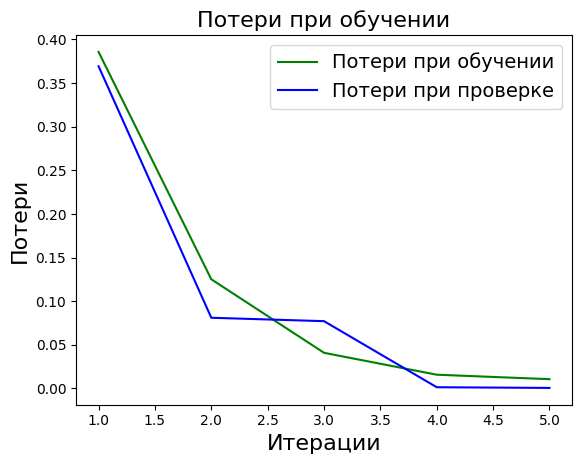

In [224]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'g', label='Потери при обучении')
plt.plot(epochs, val_loss_values, 'b', label='Потери при проверке')

plt.title('Потери при обучении', fontsize = 16)
plt.xlabel('Итерации', fontsize = 16)
plt.ylabel('Потери', fontsize = 16)
plt.legend(fontsize = 14)

plt.show()

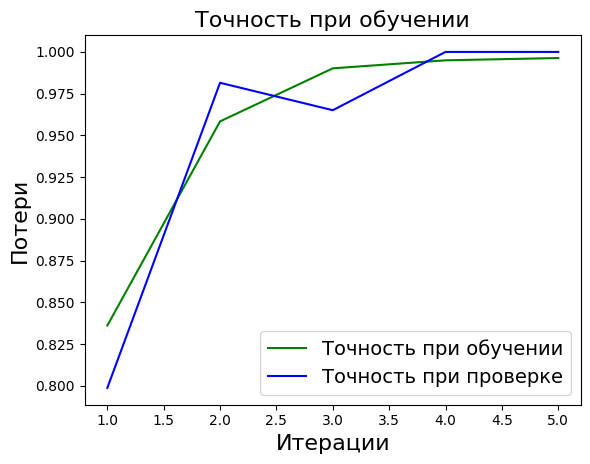

In [233]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, acc_values, 'g', label='Точность при обучении')
plt.plot(epochs, val_acc_values, 'b', label='Точность при проверке')

plt.title('Точность при обучении', fontsize = 16)
plt.xlabel('Итерации', fontsize = 16)
plt.ylabel('Потери', fontsize = 16)
plt.legend(fontsize = 14)

plt.show()

Предсказание по обученной модели

In [234]:
news_check = 'Часть материалов, касающихся расследования терактов на "Северных потоках", может быть засекречена, сообщили РИА Новости в пресс-службе шведской прокуратуры. Ранее прокурор Швеции Матс Юнгквист, возглавляющий соответствующее расследование, заявил, что рассчитывает осенью предъявить обвинения лицам, виновным в терактах.'

news_check

'Часть материалов, касающихся расследования терактов на "Северных потоках", может быть засекречена, сообщили РИА Новости в пресс-службе шведской прокуратуры. Ранее прокурор Швеции Матс Юнгквист, возглавляющий соответствующее расследование, заявил, что рассчитывает осенью предъявить обвинения лицам, виновным в терактах.'

Токенизация

In [186]:
nc_tokens = words_numbers_only(news_check)

nc_tokens

['часть',
 'материалов',
 'касающихся',
 'расследования',
 'терактов',
 'на',
 'северных',
 'потоках',
 'может',
 'быть',
 'засекречена',
 'сообщили',
 'риа',
 'новости',
 'в',
 'пресс-службе',
 'шведской',
 'прокуратуры',
 'ранее',
 'прокурор',
 'швеции',
 'матс',
 'юнгквист',
 'возглавляющий',
 'соответствующее',
 'расследование',
 'заявил',
 'что',
 'рассчитывает',
 'осенью',
 'предъявить',
 'обвинения',
 'лицам',
 'виновным',
 'в',
 'терактах']

Нормализация

In [187]:
nc_normalized = remove(nc_tokens)

nc_normalized

['часть',
 'материалов',
 'касающихся',
 'расследования',
 'терактов',
 'северных',
 'потоках',
 'засекречена',
 'сообщили',
 'риа',
 'новости',
 'пресс-службе',
 'шведской',
 'прокуратуры',
 'ранее',
 'прокурор',
 'швеции',
 'матс',
 'юнгквист',
 'возглавляющий',
 'соответствующее',
 'расследование',
 'заявил',
 'рассчитывает',
 'осенью',
 'предъявить',
 'обвинения',
 'лицам',
 'виновным',
 'терактах']

Лемматизация

In [188]:
nc_lemmas = lemmatize_state(nc_normalized)

nc_lemmas

['часть',
 'материал',
 'касаться',
 'расследование',
 'теракт',
 'северный',
 'поток',
 'засекречивать',
 'сообщать',
 'риа',
 'новость',
 'пресс-служба',
 'шведский',
 'прокуратура',
 'ранее',
 'прокурор',
 'швеция',
 'матс',
 'юнгквист',
 'возглавлять',
 'соответствующий',
 'расследование',
 'заявлять',
 'рассчитывать',
 'осень',
 'предъявлять',
 'обвинение',
 'лицо',
 'виновный',
 'теракт']

Векторизация

In [229]:
nc_vectorized = [j for i in nc_lemmas for j in vectorize(i)]

nc_vectorized = [nc_vectorized]
nc_vectorized[0]

[-0.06401851,
 -0.43362692,
 -0.36161095,
 -0.13307194,
 0.2581884,
 0.21732187,
 -0.03664765,
 0.3513089,
 -0.20271736,
 -0.30687577,
 0.056268778,
 0.19899794,
 0.18719879,
 0.056648795,
 0.28829038,
 0.4460663,
 -0.18616153,
 0.014732139,
 -0.2834928,
 -0.36241812,
 0.034724746,
 0.15830284,
 0.08217123,
 -0.022186162,
 0.08468369,
 -0.021692587,
 -0.2697643,
 0.1828372,
 -0.040689133,
 0.03386948,
 -0.01700658,
 -0.42193112,
 0.12833576,
 -0.15643479,
 -0.27698526,
 0.062117208,
 -0.16677481,
 -0.64181083,
 -0.020547083,
 -0.2265955,
 0.28804064,
 -0.029354768,
 0.30918568,
 0.05981332,
 0.08861331,
 -0.013750914,
 0.29209706,
 -0.08082713,
 -0.25655162,
 -0.2518621,
 -0.16152903,
 -0.06688735,
 0.19586979,
 -0.1739645,
 0.032930378,
 -0.24708821,
 0.16863886,
 0.4905702,
 -0.58160096,
 0.13179745,
 -0.28499618,
 -0.26118875,
 0.1747004,
 -0.38879284,
 0.027828787,
 -0.19862543,
 0.16578712,
 0.42590752,
 -0.032068808,
 0.16357434,
 0.3462459,
 -0.060500663,
 -0.40715232,
 0.217176

In [190]:
nc_vectorized[0] = nc_vectorized[0][:MAX_NEWS_LEN]

In [197]:
len(nc_vectorized[0])

74400

In [196]:
x_predict = pad_sequences(nc_vectorized, maxlen=MAX_NEWS_LEN, dtype='float32')
len(x_predict[0])

80000

In [198]:
x_predict = numpy.reshape(x_predict, (1, 1, MAX_NEWS_LEN))

In [199]:
x_predict.shape

(1, 1, 80000)

In [200]:
news_model = model.predict(x_predict)

1/1 [==============================] - 0s 38ms/step


c:\Users\79141\AppData\Local\pypoetry\Cache\virtualenvs\classification-news-BOnitD42-py3.9\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [201]:
news_model

array([[[0.8434682]]], dtype=float32)

Сохранение модели

In [226]:
# model.save('trained_models/news_classification_v2.h5')

Загрузка модели

In [ ]:
# tensorflow.keras.models.load_model('trained_models/news_classification_v2.h5')